# [Week6] 繁簡體電影字幕中的人名差異

## [簡介](#intro)
## [翻譯人名常用字分析](#trans)
## [繁簡體人名常用字分析](#natives)
## [電影人名翻譯差異分析](#movies)
## [討論](#discussion)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import re
import src.cgroup_preproc as precg
import src.name_preproc as prename
import src.ngram_preproc as preproc
import src.srtloader as srt
import src.align_srt as align
import matplotlib.pyplot as plt
import numpy as np
from LingPlus import ner

# 簡介<a name="intro"></a>

<div style="font-size: large; line-height: 175%; width: 80%; margin-top:1em">
此專案嘗試使用常用字法來偵測並比較電影中的翻譯人名。在此方法中，我們首先分析翻譯名詞中的常用字，並以常用字的機率，來辨識文本中的人名。在翻譯名詞中，主要的資料來源是Wikipedia的繁簡對應表，其中有四份人名對應是和此辨識作業息息相關的，亦即藝人譯名、美國總統譯名、英國政治人物譯名以及人名譯名。從這些對應表中，我們分析出每個單字以及每個二字組的出現頻率，並以此出現頻率來計算一個二字組是譯名的機率。最後，將句子中連續高於一定閾值的字串當成是人名。中文姓名的資料來源則是2012年的大學入學榜單，以及大陸2014年一部份的高考榜單。偵測中文人名的方式，除資料來源不同以外，其餘皆和譯名的計算方式相同。

</div>

# 翻譯人名常用字分析<a name="trans"></a>

### 從Wikipedia讀取CGroup 資料

In [3]:
cg_dict = {}
for cg_path in glob.glob("data/cgroup/CGroup*.txt"):
    cg_dict.update(precg.extract_cgroup(cg_path))
print("tw-cn name translation pairs loaded: %d" % len(cg_dict))

tw-cn name translation pairs loaded: 1205


In [4]:
iter_vals = iter(cg_dict.values())
[next(iter_vals) for _ in range(10)]

[('阿基里斯', '阿喀琉斯'),
 ('艾爾', '阿尔'),
 ('亞歷', '亚历克'),
 ('艾倫', '艾伦'),
 ('亞歷克賽', '阿列克谢'),
 ('亞歷山德拉', '亚历山德拉'),
 ('亞盧夏', '阿廖沙'),
 ('阿莫多瓦', '阿尔莫多瓦尔'),
 ('阿特曼', '奥特曼'),
 ('阿瑪迪斯', '阿马德乌斯')]

In [5]:
tw_bigrams = preproc.get_bigram_freq([x[0] for x in cg_dict.values()])
cn_bigrams = preproc.get_bigram_freq([x[1] for x in cg_dict.values()])
tw_unigrams = preproc.get_unigram_freq([x[0] for x in cg_dict.values()])
cn_unigrams = preproc.get_unigram_freq([x[1] for x in cg_dict.values()])

## 單雙字組頻率 - TW

In [6]:
preproc.print_dict_by_freq(tw_unigrams)
preproc.print_dict_by_freq(tw_bigrams)

[('斯', 269), ('克', 209), ('爾', 121), ('特', 121), ('德', 120), ('艾', 72), ('史', 70), ('拉', 69), ('莉', 67), ('森', 66)]
[('里斯', 35), ('克里', 31), ('約翰', 21), ('克斯', 18), ('布萊', 16), ('詹姆', 16), ('麥可', 16), ('姆斯', 15), ('湯姆', 15), ('喬治', 14)]


## 單雙字組頻率 - CN

In [7]:
preproc.print_dict_by_freq(cn_unigrams)
preproc.print_dict_by_freq(cn_bigrams)

[('斯', 364), ('尔', 265), ('克', 251), ('特', 188), ('德', 173), ('里', 130), ('拉', 95), ('姆', 82), ('罗', 77), ('布', 75)]
[('里斯', 37), ('克里', 34), ('约翰', 29), ('克尔', 28), ('姆斯', 25), ('迈克', 25), ('斯特', 24), ('克斯', 21), ('尔斯', 19), ('罗伯', 18)]


## 計算任意雙字組可能是人名的分數

$$
score(\textrm{isName}) = p(C_1, C_2) = \lambda \cdot \frac{f(C_1, C_2) + \alpha}{Z_{(C_1, C_2)}} + 
(1-\lambda) \cdot \frac{f(C_2) + \alpha}{Z_{C_2}}
$$

where $Z_{x}$ is the normalization constant (including smoothing), $f(.)$ indicates the frequency occurred in corpus;  
$\alpha$ is smoothing parameter, and $\lambda$ is interpolation parameter.

['傑克', '麥斯']


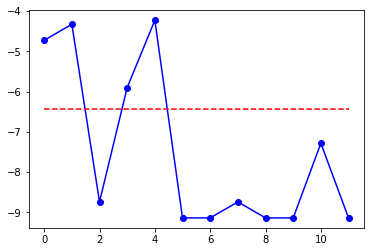

In [8]:
nd = ner.NameDetection(tw_unigrams, tw_bigrams)
crit = nd.update_criterion([x[0] for x in cg_dict.values()], 90)
txt = "傑克與麥斯必須與時間賽跑"
prob_vec = nd.compute_transName_prob(txt)
plt.plot(prob_vec, 'bo-')
plt.plot([0, len(prob_vec)-1], [crit, crit], 'r--')
print(nd.get_names(txt))

# 繁簡體人名常用字分析<a name="natives"></a>

## 讀取繁體中文姓名

In [9]:
tw_names = prename.preproc_twname_data("data/names/2012.txt")
print("number of tw names loaded: %d" % len(tw_names))        

number of tw names loaded: 59693


## 讀取簡體中文姓名

In [10]:
cn_names = []
for fpath in glob.glob("data/names/2014_cn_*.txt"):
    cn_names += prename.preproc_cnname_data(fpath)
print("number of cn names loaded: %d" % len(cn_names))         

number of cn names loaded: 6924


In [11]:
print("tw family names")    
print(tw_names[0:10])
print("cn family names")    
print(cn_names[0:10])

tw family names
['王麒雲', '沈楚柔', '楊淑雯', '關天惠', '楊琇荏', '張筱晴', '吳太一', '林家瑜', '曾鈺雯', '林雨儂']
cn family names
['尹娜', '张贤', '秦臻', '李真', '白婉莹', '程红', '张贺', '杨舒皓', '李新瑶', '王少莆']


In [12]:
tw_names_unigram = preproc.get_unigram_freq(tw_names)
tw_names_bigram = preproc.get_bigram_freq(tw_names)
cn_names_unigram = preproc.get_unigram_freq(cn_names)
cn_names_bigram = preproc.get_bigram_freq(cn_names)

In [13]:
prename.print_dict_by_freq(tw_names_unigram)
prename.print_dict_by_freq(cn_names_unigram)
prename.print_dict_by_freq(tw_names_bigram)
prename.print_dict_by_freq(cn_names_bigram)

[('陳', 6639), ('林', 5008), ('黃', 3807), ('張', 3179), ('李', 3164), ('王', 2434), ('吳', 2408), ('劉', 1920), ('蔡', 1634), ('楊', 1560)]
[('王', 721), ('张', 692), ('李', 614), ('刘', 334), ('宇', 308), ('赵', 299), ('杨', 270), ('晓', 226), ('郭', 191), ('文', 169)]
[('陳冠', 288), ('陳怡', 242), ('陳柏', 232), ('陳彥', 208), ('陳昱', 160), ('陳奕', 150), ('李佳', 141), ('林佳', 137), ('張家', 130), ('張雅', 127)]
[('泽宇', 23), ('张晓', 23), ('王泽', 19), ('王晓', 19), ('王佳', 16), ('王宇', 16), ('张文', 15), ('杨晓', 15), ('王文', 14), ('晓宇', 13)]


In [14]:
zhND = ner.NameDetection(tw_names_unigram, tw_names_bigram)
zhND.setLambda(0.2)
crit = zhND.update_criterion(tw_names, 80)
txt = "立委陳明文在採訪中表示"
vec = zhND.compute_transName_prob(txt)
print(zhND.get_names(txt))

['陳明文']


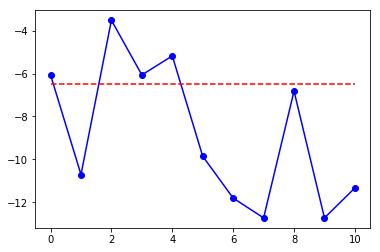

In [15]:
plt.plot(vec,'bo-')
plt.plot([0,len(vec)-1], [crit,crit], 'r--')

# 電影人名翻譯差異分析 <a name="movies"></a>

In [16]:
srt_aligned = []
for srtdir in glob.glob("data/srt/*/"):
    print(srtdir)
    tw_srt = srt.load_srt(srtdir + "TW.srt")
    cn_srt = srt.load_srt(srtdir + "CN.srt")
    aligned_cn_tw = align.align_srt(tw_srt, cn_srt)
    sanitize_str = lambda x: re.sub("[\s-]", "", x)
    tw_txt = (sanitize_str(x["text"]) for x in tw_srt)
    cn_txt = (sanitize_str(cn_srt[cn_i]["text"]) for cn_i in aligned_cn_tw)
    srt_aligned += [(x, y) for x, y in zip(tw_txt, cn_txt)]

srt_aligned[:10]

data/srt\Baby_Driver_2017\
data/srt\Inception_2010\
data/srt\Inferno_2016\
data/srt\Schindlers_List_1993\
data/srt\Spider-Man_Homecoming_2017\
data/srt\Wonder_Woman_2017\


[('（銀行）', '亚特兰大第一银行'),
 ('（現在播放："喇叭褲"）', 'JonSpencerBluesExplosion乐队喇叭裤'),
 ('手舉高趴在地上', '举起手！马上趴在地上！'),
 ('給我趴在地上，趴下', '我要你们趴在地上！趴下！'),
 ('趴下，不准動', '趴下！别动！'),
 ('快…', '走走走！'),
 ('快點…', '快走快走！'),
 ('通通不准動', '所有人不能动！'),
 ('趴下！', '所有人不能动！'),
 ('…駕駛紅色速霸陸WRX', '<i>…驾驶一辆红色速霸路WRX</i>')]

In [17]:
twND = ner.NameDetection(tw_unigrams, tw_bigrams)
twND.update_criterion([x[0] for x in cg_dict.values()], 80)
cnND = ner.NameDetection(cn_unigrams, cn_bigrams)
cnND.update_criterion([x[0] for x in cg_dict.values()], 80)

-9.2140179085958085

In [18]:
import pandas as pd
ent_list = []
for tw_x, cn_x in srt_aligned:
    tw_ents = twND.get_names(tw_x)
    cn_ents = cnND.get_names(cn_x)
    if len(tw_ents) > 1 or len(cn_ents) > 1:
        continue
    if tw_ents and cn_ents:
        ent_list.append((tw_x, tw_ents[0], cn_x, cn_ents[0]))    
ent_mapped = pd.DataFrame(ent_list, columns=["TW-subs", "TW-ents", "CN-subs", "CN-ents"])


## 從字幕中擷取出的譯名配對

In [19]:
ent_pairs = ent_mapped.groupby(["TW-ents", "CN-ents"]).count()
ent_pairs['CN-ents'] = [x[1] for x in ent_pairs.index.values]
ent_pairs = ent_pairs.drop('CN-subs', axis=1)
ent_pairs.columns = ['count', 'CN-ents']
ent_pairs.iloc[:20, :]

count  CN-ents
TW-ents CN-ents                
丹麥      弗拉什          1      弗拉什
亞特蘭大    亚特兰大         5     亚特兰大
亞瑟      亚瑟           7       亚瑟
        他好           1       他好
        哈亚瑟          1      哈亚瑟
亞當      好亚当          1      好亚当
亞馬遜     亚马逊人         6     亚马逊人
        亚马逊女王        1    亚马逊女王
        他和亚马逊女王      1  他和亚马逊女王
伊姆斯     伊姆斯          5      伊姆斯
伊斯坦     伊斯坦布尔        2    伊斯坦布尔
        伊斯坦布尔大       1   伊斯坦布尔大
        伊斯坦布尔大街      1  伊斯坦布尔大街
伊斯梅爾    伊斯梅尔         1     伊斯梅尔
伊格納     伊格纳奇奥        8    伊格纳奇奥
伊瑪      伊玛依          2      伊玛依
伊莉莎白    伊丽莎白         6     伊丽莎白
佛羅倫斯    丁热爱佛罗伦萨      1  丁热爱佛罗伦萨
        佛罗伦萨         5     佛罗伦萨
傑克      杰克后          1      杰克后

## 在每個繁體人名中，僅選取一個出現次數最高的簡體對應

In [20]:
ent_proc = ent_pairs.sort_values('count', ascending=False).groupby(['TW-ents']).first()
ent_proc = ent_proc[["CN-ents", 'count']]
ent_proc = ent_proc.loc[ent_proc["count"]>1,:]
ent_proc.sort_values('count', ascending=False)


,CN-ents,count
TW-ents,,
黛安娜,戴安娜,40
東西,东西,28
阿瑞斯,阿瑞斯,20
蘭登,兰登,17
柯柏,柯布,16
史提夫,史蒂夫,11
斯特恩,斯特恩,10
布里斯特,佐布里斯特,10
彼得,彼得,8


# 討論 <a name="discussion"></a>

* 即便是一個簡單的常用字機率模型，經過一些限制（constraints）後，仍然可以發現繁簡體人名翻譯的不同。
* 從上述對應表中，很明顯的觀察到幾個可改善的地方。例如，「東西」被錯誤的當成人名，這可能來自於「東」和「西」各字都是翻譯常用字（安東尼、潔西卡等）。有些譯名則被截斷或有些字錯誤的被當作人名。
* 這些錯誤可能大部分來自於常用字方法將每個字視為獨立的成分，失去很多的脈絡訊息。
* 由於這些電影中沒有中文人名，所以並未使用到中文人名偵測。而事實上中文人名從某個角度上比翻譯人名複雜，因為中文人名中的姓和名應有相依性，亦即一個字被當成姓，會暗示後面的一或兩個字應該要是人名。但這個訊息是常用字方法無法觸及的。

# Appendix: 繁簡體常用姓氏

## preprocess family names (tw/cn)

In [21]:
from bs4 import BeautifulSoup
def load_family_names(wikipath):
    with open(wikipath, "r", encoding="UTF-8") as fin:
        tree = BeautifulSoup(fin, "lxml")
    fnames_elem = tree.select("table.wikitable p a['title']")
    fnames = [x.text for x in fnames_elem]
    return(fnames)
tw_family_names = load_family_names("data/names/tw_last_names.html")
cn_family_names = load_family_names("data/names/cn_last_names.html")

In [22]:
print(tw_family_names[:20])
print(cn_family_names[:20])

['趙', '錢', '孫', '李', '周', '吳', '鄭', '王', '馮', '陳', '褚', '衛', '蔣', '沈', '韓', '楊', '朱', '秦', '尤', '許']
['赵', '钱', '孙', '李', '周', '吴', '郑', '王', '冯', '陈', '褚', '卫', '蒋', '沈', '韩', '杨', '朱', '秦', '尤', '许']


In [23]:
def compute_family_name_freq(names, fnames):
    fn_dict = {}
    name_list = []
    fnames = sorted(fnames, key=lambda x: len(x), reverse=True)
    for name_x in names:
        for fn_x in fnames:
            if not name_x.startswith(fn_x): continue
            # ignore the cases where whole name euqal to family names
            # they might be ligit names, but skip them for now
            if len(name_x) == len(fn_x): continue
            fn_dict[fn_x] = fn_dict.get(fn_x, 0) + 1            
            name_list.append(name_x[len(fn_x):])
            break
    return name_list, fn_dict
cn_first_names, cn_family_names_freq = compute_family_name_freq(cn_names, cn_family_names)
tw__first_names, tw_family_names_freq = compute_family_name_freq(tw_names, tw_family_names)

In [24]:
preproc.print_dict_by_freq(tw_family_names_freq)
preproc.print_dict_by_freq(cn_family_names_freq)

[('陳', 6628), ('林', 4950), ('黃', 3799), ('張', 3173), ('李', 3159), ('王', 2422), ('吳', 2405), ('劉', 1916), ('蔡', 1632), ('楊', 1551)]
[('王', 719), ('张', 690), ('李', 608), ('刘', 333), ('赵', 296), ('杨', 255), ('郭', 190), ('陈', 129), ('马', 124), ('高', 124)]
